In [253]:
from collections import defaultdict
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import sys

In [93]:
plt.rcParams.update({'font.size': 22})

In [94]:
market_area = 'denver'

In [95]:
listings_df = pd.read_csv(f'{market_area}_listing_dates_with_ct.csv')

In [96]:
listings_df['ct_key'] = listings_df['ct_key'].astype('int')
listings_df['list_month'] = (pd.to_datetime(listings_df['list_date']) + 
                                            pd.offsets.MonthBegin(n=1) - pd.offsets.MonthBegin(n=1))
listings_df['sale_month'] = (pd.to_datetime(listings_df['sale_date']) + 
                                            pd.offsets.MonthBegin(n=1) - pd.offsets.MonthBegin(n=1))

In [97]:
num_listings_ct = (listings_df.dropna(subset=['list_month'])
                   .groupby(['ct_key', 'list_month']).count()[['property_id']].reset_index())
num_listings_ct = num_listings_ct.rename(columns={'property_id':'ct_count_listings', 'list_month':'month'})

num_sales_ct = (listings_df.dropna(subset=['sale_month'])
                .groupby(['ct_key', 'sale_month']).count()[['property_id']].reset_index())
num_sales_ct = num_sales_ct.rename(columns={'property_id':'ct_count_sales', 'sale_month':'month'})

num_sales_listings_df = pd.merge(num_listings_ct, num_sales_ct, left_on=['month','ct_key'], 
                                 right_on=['month','ct_key'], how='outer')
num_sales_listings_df = num_sales_listings_df.fillna(0.)

In [98]:
num_sales_listings_df.head()

,ct_key,month,ct_count_listings,ct_count_sales
0,8001007801,2016-03-01,3.0,3.0
1,8001007801,2016-04-01,3.0,1.0
2,8001007801,2016-05-01,4.0,2.0
3,8001007801,2016-06-01,5.0,2.0
4,8001007801,2016-07-01,1.0,2.0


In [99]:
ct_stats_df = pd.read_csv(f'{market_area}_census_tract_data_updated.csv')
ct_stats_df = ct_stats_df[['ct_key', 'total_households']]

In [100]:
df_merged = pd.merge(ct_stats_df, num_sales_listings_df, left_on='ct_key', right_on='ct_key')

In [101]:
df_merged.head()

,ct_key,total_households,month,ct_count_listings,ct_count_sales
0,8001007801,1280,2016-03-01,3.0,3.0
1,8001007801,1280,2016-04-01,3.0,1.0
2,8001007801,1280,2016-05-01,4.0,2.0
3,8001007801,1280,2016-06-01,5.0,2.0
4,8001007801,1280,2016-07-01,1.0,2.0


In [102]:
listing_sales_overall = num_sales_listings_df.groupby(['ct_key','month']).agg(
    {'ct_count_listings':'mean', 'ct_count_sales':'mean'}).reset_index()
listing_sales_overall = listing_sales_overall.groupby('month').agg(
    {'ct_count_listings':'sum', 'ct_count_sales':'sum'})

# sum up number of households for all CT in the house listing dataset and the CT-level feature dataset
listing_sales_overall['total_households'] = ct_stats_df[ct_stats_df['ct_key'].isin(
    num_sales_listings_df.ct_key.unique())]['total_households'].sum()

listing_sales_overall['sales_per_households'] = (listing_sales_overall['ct_count_sales'] /
                                                 listing_sales_overall['total_households'])
listing_sales_overall['listings_per_households'] = (listing_sales_overall['ct_count_listings'] /
                                                    listing_sales_overall['total_households'])

In [103]:
df_merged = pd.merge(df_merged, listing_sales_overall[['sales_per_households', 'listings_per_households']], 
                     left_on='month', right_index=True)
df_merged['ct_listings_per_households'] = df_merged['ct_count_listings'] / df_merged['total_households']
df_merged['ct_sales_per_households'] = df_merged['ct_count_sales'] / df_merged['total_households']

df_merged['relative_listings_toBaseline'] = (df_merged['ct_listings_per_households'] / 
                                             df_merged['listings_per_households'])
df_merged['relative_sales_toBaseline'] = df_merged['ct_sales_per_households'] / df_merged['sales_per_households']

In [104]:
df_merged.head()

,ct_key,total_households,month,ct_count_listings,ct_count_sales,sales_per_households,listings_per_households,ct_listings_per_households,ct_sales_per_households,relative_listings_toBaseline,relative_sales_toBaseline
0,8001007801,1280,2016-03-01,3.0,3.0,0.003853,0.00948,0.002344,0.002344,0.247220,0.608242
55,8001007802,1445,2016-03-01,4.0,1.0,0.003853,0.00948,0.002768,0.000692,0.291988,0.179596
105,8001007900,1904,2016-03-01,15.0,7.0,0.003853,0.00948,0.007878,0.003676,0.830993,0.954104
162,8001008000,1774,2016-03-01,13.0,7.0,0.003853,0.00948,0.007328,0.003946,0.772970,1.024022
221,8001008200,1528,2016-03-01,8.0,5.0,0.003853,0.00948,0.005236,0.003272,0.552255,0.849203


In [105]:
droppped_ct = df_merged.groupby('ct_key').count()['ct_count_sales'].reset_index(name='count')
droppped_ct = droppped_ct[droppped_ct['count']<10]['ct_key'].values
droppped_ct

array([8001008100, 8039961206, 8039961208, 8041007500, 8069000600,
       8123002005, 8123002012, 8123002501])

In [106]:
# drop census tract with too few data (only 1/2 months of available data)
df_merged = df_merged[~df_merged['ct_key'].isin(droppped_ct)]
print(df_merged.shape)

print(df_merged.ct_key.nunique())
print(len(df_merged))

(42089, 11)
746
42089


In [107]:
df_merged.head()

,ct_key,total_households,month,ct_count_listings,ct_count_sales,sales_per_households,listings_per_households,ct_listings_per_households,ct_sales_per_households,relative_listings_toBaseline,relative_sales_toBaseline
0,8001007801,1280,2016-03-01,3.0,3.0,0.003853,0.00948,0.002344,0.002344,0.247220,0.608242
55,8001007802,1445,2016-03-01,4.0,1.0,0.003853,0.00948,0.002768,0.000692,0.291988,0.179596
105,8001007900,1904,2016-03-01,15.0,7.0,0.003853,0.00948,0.007878,0.003676,0.830993,0.954104
162,8001008000,1774,2016-03-01,13.0,7.0,0.003853,0.00948,0.007328,0.003946,0.772970,1.024022
221,8001008200,1528,2016-03-01,8.0,5.0,0.003853,0.00948,0.005236,0.003272,0.552255,0.849203


In [350]:
# exclude month of November as it is not over yet at this time
df_merged = df_merged[df_merged['month'] != datetime.datetime(2020, 11, 1)]

### Time series analysis

In [109]:
groupby_df = df_merged.groupby('ct_key')

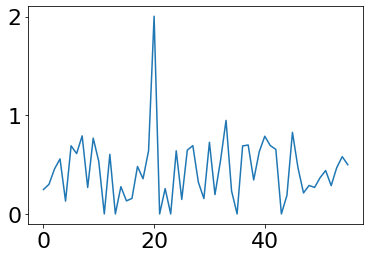

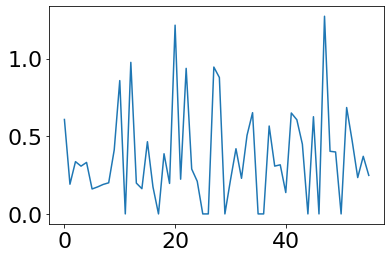

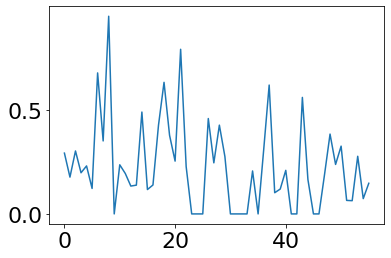

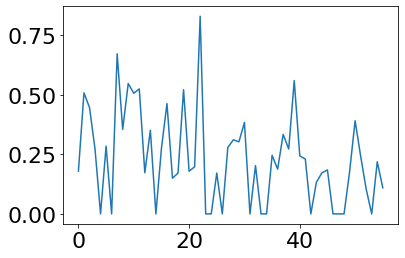

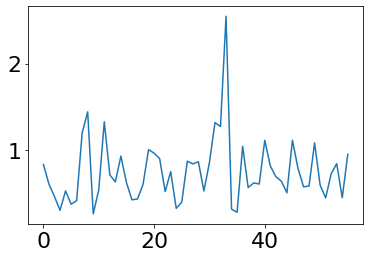

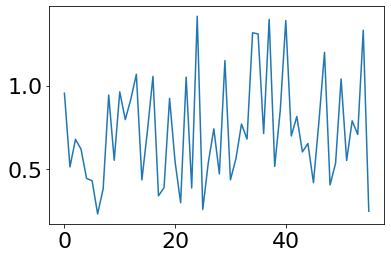

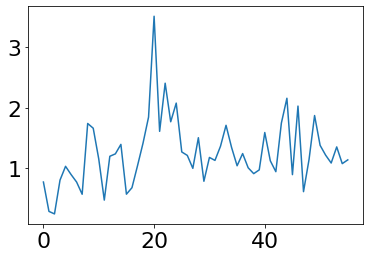

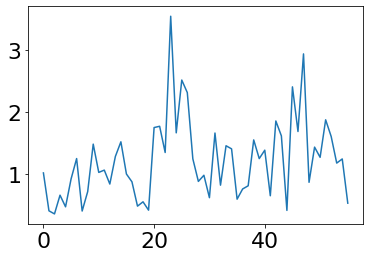

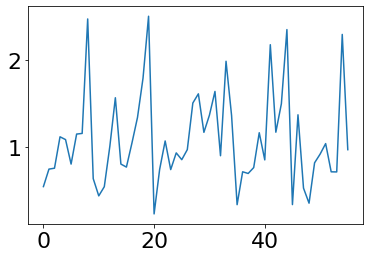

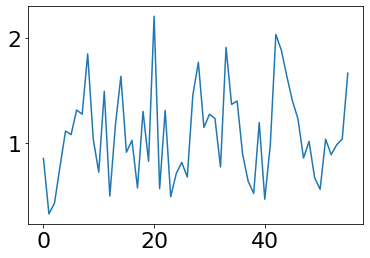

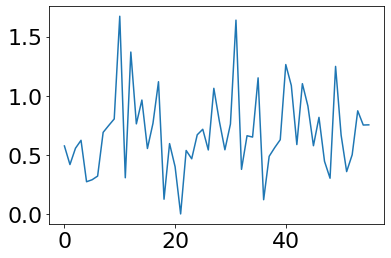

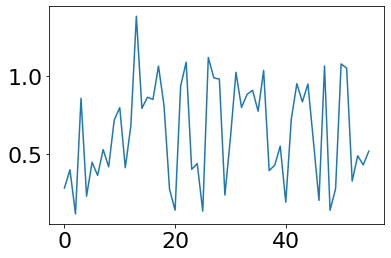

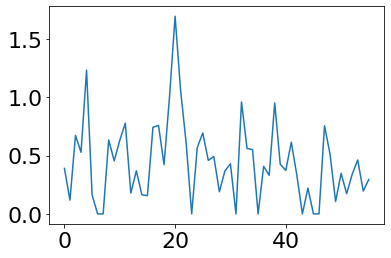

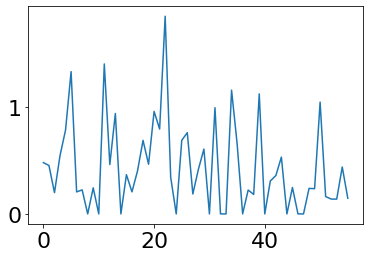

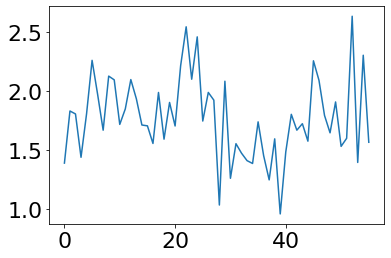

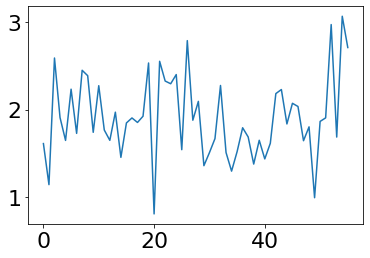

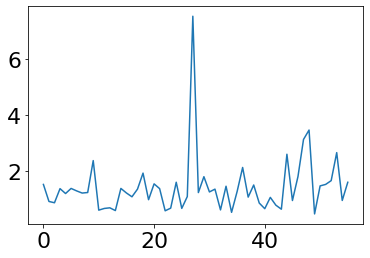

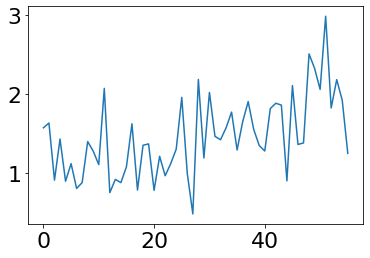

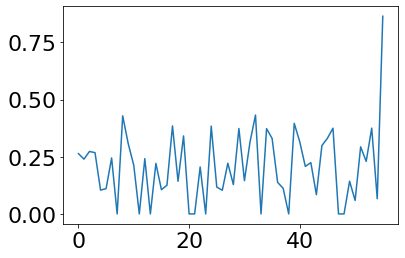

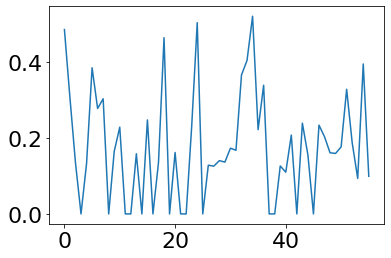

In [110]:
lin_reg = LinearRegression()
listings_slopes = []
sales_slopes = []
all_months = sorted(list(set(df_merged['month'])))
x_vals = np.arange(len(all_months)).reshape(-1, 1)
cnt = 0
for ct_key, df in groupby_df:
    household_num = list(df['total_households'])[0]
    listings_lst = []
    sales_lst = []
    for month in all_months:
        try:
            relative_listing_rate = list(df[df['month'] == month]['relative_listings_toBaseline'])[0]
            relative_sales_rate = list(df[df['month'] == month]['relative_sales_toBaseline'])[0]
        except IndexError:
            relative_listing_rate = 0 
            relative_sales_rate = 0
        listings_lst.append(relative_listing_rate)
        sales_lst.append(relative_sales_rate)
    
    lin_reg.fit(x_vals, listings_lst)
    listings_slopes.append(lin_reg.coef_[0])
    
    lin_reg.fit(x_vals, sales_lst)
    sales_slopes.append(lin_reg.coef_[0])
    
    if cnt < 10:
        plt.plot(listings_lst)
        plt.show()
        plt.plot(sales_lst)
        plt.show()
        
    cnt += 1

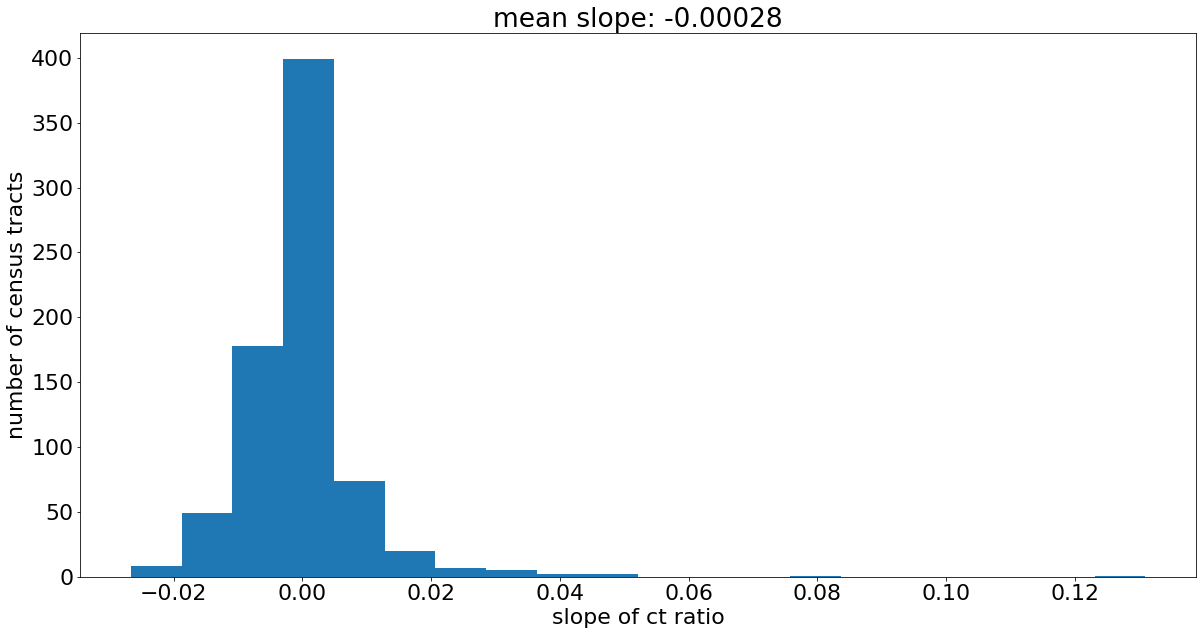

In [111]:
plt.figure(figsize=(20, 10))
plt.hist(listings_slopes, bins=20)
plt.xlabel('slope of ct ratio')
plt.ylabel('number of census tracts')
plt.title(f'mean slope: {round(np.mean(listings_slopes), 5)}')
plt.show()

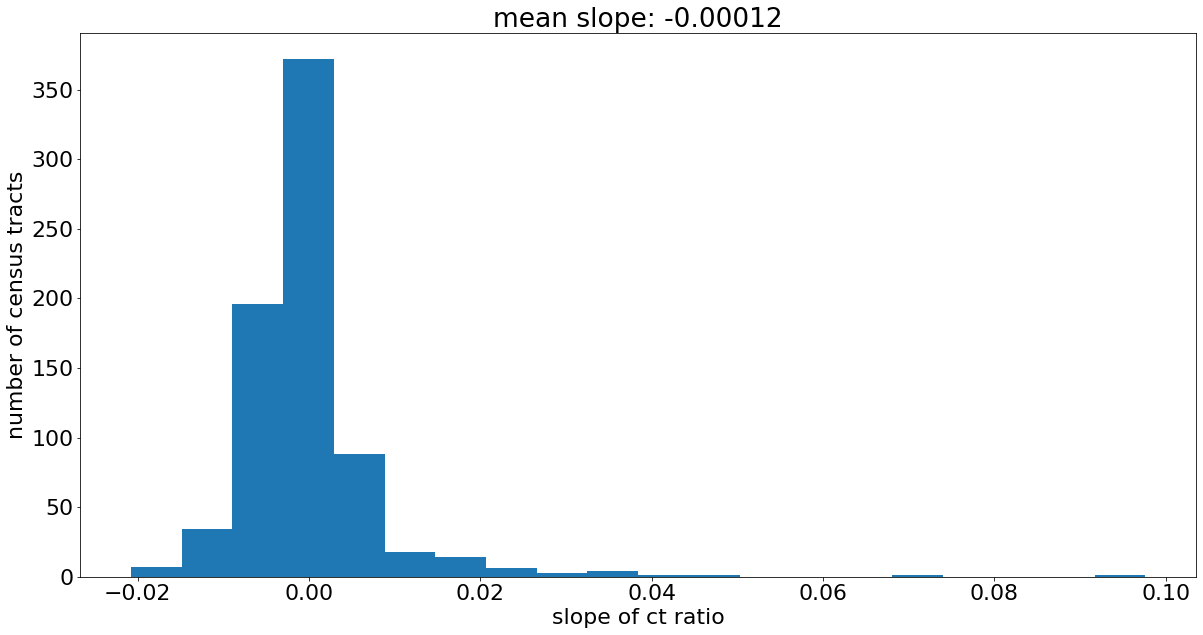

In [112]:
plt.figure(figsize=(20, 10))
plt.hist(sales_slopes, bins=20)
plt.xlabel('slope of ct ratio')
plt.ylabel('number of census tracts')
plt.title(f'mean slope: {round(np.mean(sales_slopes), 5)}')
plt.show()

## Evaluation on test set

In [331]:
print('mean monthly listings per CT:', np.mean(df_merged.ct_count_listings))
print('mean monthly sales per CT:', np.mean(df_merged.ct_count_sales))

mean monthly listings per CT: 10.61522479646317
mean monthly sales per CT: 7.83088928079627


In [332]:
test_set_months = 12

In [333]:
def weighted_absolute_percentage_error(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

In [334]:
months_sorted = sorted(set(df_merged['month']))
test_months = months_sorted[-test_set_months:]
train_df = df_merged[~df_merged['month'].isin(test_months)]
test_df = df_merged[df_merged['month'].isin(test_months)]

In [346]:
# baseline model (same prediction for each census tract)
def evaluate_baseline_model(category):
    predicted_value = test_df[f'{category}_per_households'] * test_df['total_households']
    true_value = test_df[f'ct_count_{category}']
    mae = mean_absolute_error(true_value, predicted_value)
    wape = weighted_absolute_percentage_error(true_value, predicted_value)


    plt.figure(figsize=(20, 10))
    plt.hist(true_value - predicted_value, bins=20, density=True)
    plt.xlabel(f'actual {category} - predicted {category}')
    plt.ylabel('density')
    plt.title(f'Baseline {category} model -- MAE: {round(mae, 3)}, WAPE: {round(wape, 3)}')
    plt.show()

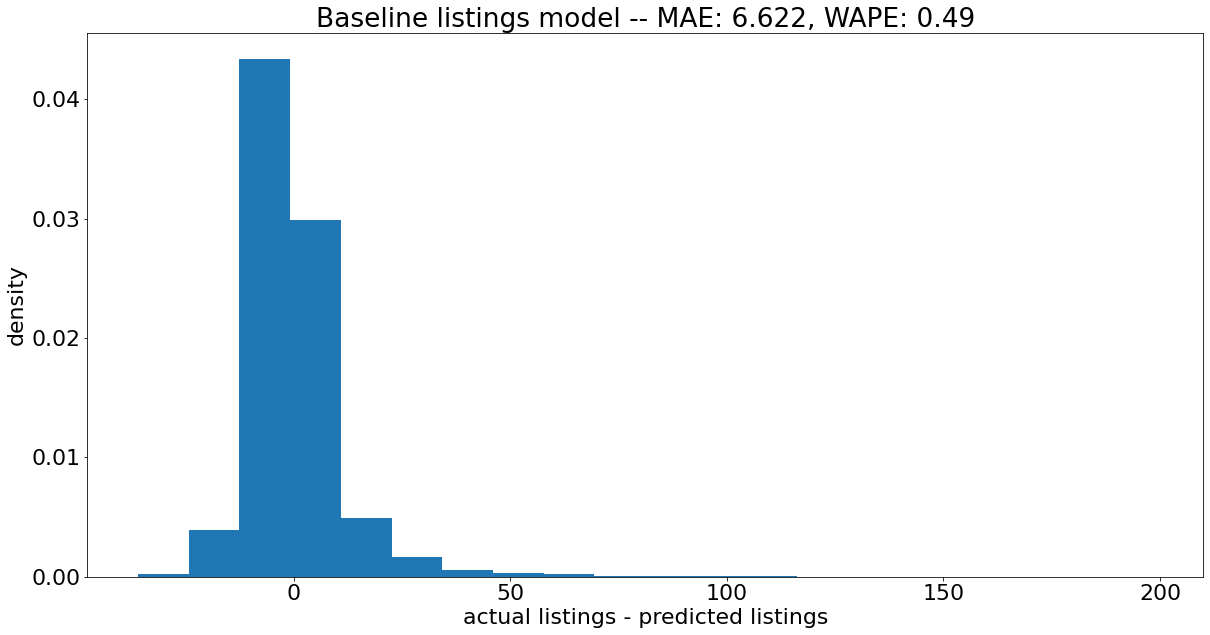

In [347]:
evaluate_baseline_model('listings')

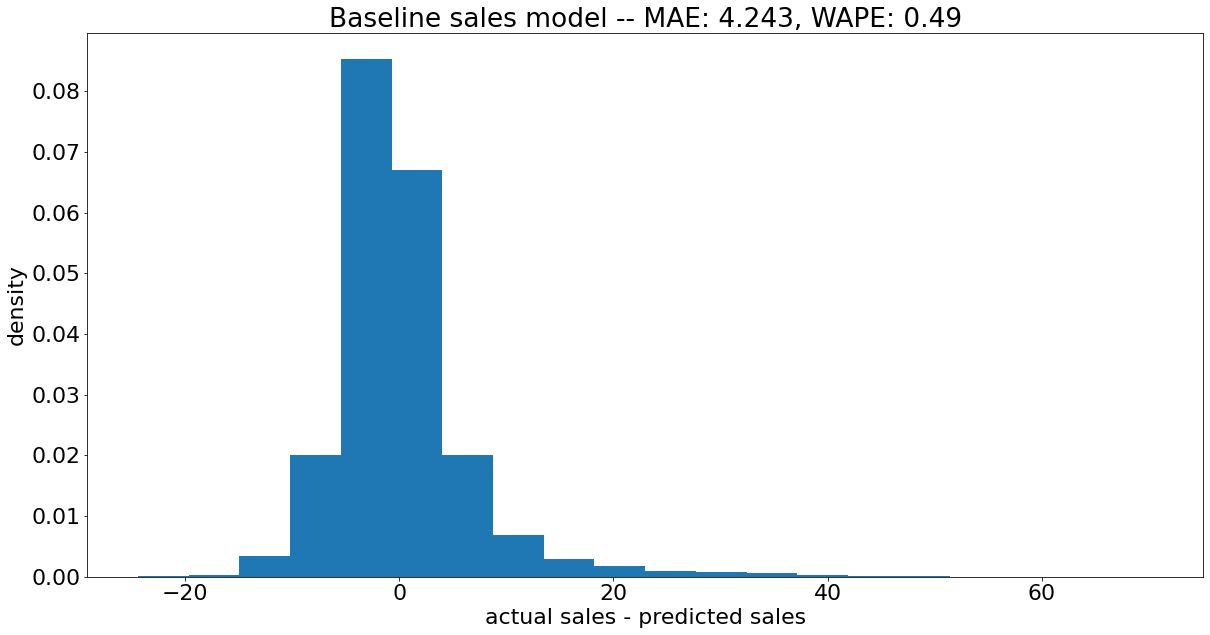

In [348]:
evaluate_baseline_model('sales')

In [338]:
ratio_param_df = train_df.groupby('ct_key').agg({'relative_listings_toBaseline': [np.mean, np.std],
                                                 'relative_sales_toBaseline': [np.mean, np.std]})

In [339]:
ratio_param_df.columns = ['listings_mean', 'listings_std', 'sales_mean', 'sales_std']

In [340]:
ratio_param_df.head()

,listings_mean,listings_std,sales_mean,sales_std
ct_key,,,,
8001007801,0.476216,0.355788,0.383103,0.301978
8001007802,0.281546,0.229595,0.294230,0.193388
8001007900,0.754829,0.413836,0.734213,0.326428
8001008000,1.233236,0.577939,1.169168,0.631349
8001008200,1.111826,0.517075,1.085914,0.474369


In [341]:
groupby_test_df = test_df.groupby('ct_key')

In [342]:
alpha_level = 0.1
std_multiple = abs(norm.ppf(alpha_level / 2))

In [343]:
listings_diff = []
sales_diff = []
ct_key_to_listings_mae = {}
ct_key_to_sales_mae = {}
ct_key_to_listings_in_range_fraction = {}
ct_key_to_sales_in_range_fraction = {}
for ct_key, df in groupby_test_df:
    household_num = list(df['total_households'])[0]
    ratio_params = ratio_param_df.loc[ct_key]
    
    # point predictions
    predicted_listings = df['listings_per_households'] * ratio_params['listings_mean'] * household_num
    predicted_sales = df['sales_per_households'] * ratio_params['sales_mean'] * household_num
    actual_listings = df['ct_count_listings']
    actual_sales = df['ct_count_sales']
    listings_mae = mean_absolute_error(actual_listings, predicted_listings)
    sales_mae = mean_absolute_error(actual_sales, predicted_sales)
    ct_key_to_listings_mae[ct_key] = listings_mae
    ct_key_to_sales_mae[ct_key] = sales_mae
    listings_diff.extend(actual_listings - predicted_listings)
    sales_diff.extend(actual_sales - predicted_sales)
    
    # predictive intervals
    listings_lower_ratio_bound = max(-0.01, ratio_params['listings_mean'] - 
                                    std_multiple * ratio_params['listings_std'])
    listings_upper_ratio_bound = ratio_params['listings_mean'] + std_multiple * ratio_params['listings_std']
    lower_bound_listings = df['listings_per_households'] * listings_lower_ratio_bound * household_num
    upper_bound_listings = df['listings_per_households'] * listings_upper_ratio_bound * household_num
    is_listings_in_range = np.logical_and(np.greater(actual_listings, lower_bound_listings),
                                 np.less(actual_listings, upper_bound_listings))
    ct_key_to_listings_in_range_fraction[ct_key] = np.mean(is_listings_in_range)
    
    sales_lower_ratio_bound = max(-0.01, ratio_params['sales_mean'] - std_mutliple * ratio_params['sales_std'])
    sales_upper_ratio_bound = ratio_params['sales_mean'] + std_mutliple * ratio_params['sales_std']
    lower_bound_sales = df['sales_per_households'] * sales_lower_ratio_bound * household_num
    upper_bound_sales = df['sales_per_households'] * sales_upper_ratio_bound * household_num
    is_sales_in_range = np.logical_and(np.greater(actual_sales, lower_bound_sales),
                                 np.less(actual_sales, upper_bound_sales))
    ct_key_to_sales_in_range_fraction[ct_key] = np.mean(is_sales_in_range)

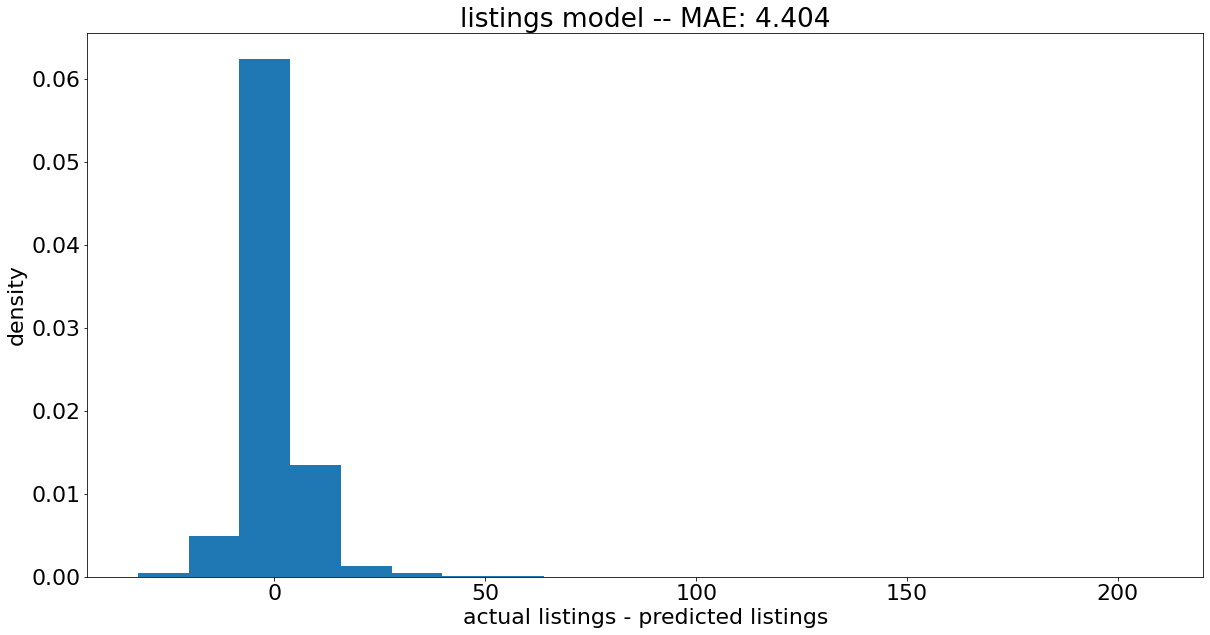

In [344]:
plt.figure(figsize=(20, 10))
plt.hist(listings_diff, bins=20, density=True)
plt.xlabel('actual listings - predicted listings')
plt.ylabel('density')
overall_mae = np.mean(list(ct_key_to_listings_mae.values()))
plt.title(f'listings model -- MAE: {round(overall_mae, 3)}')
plt.show()

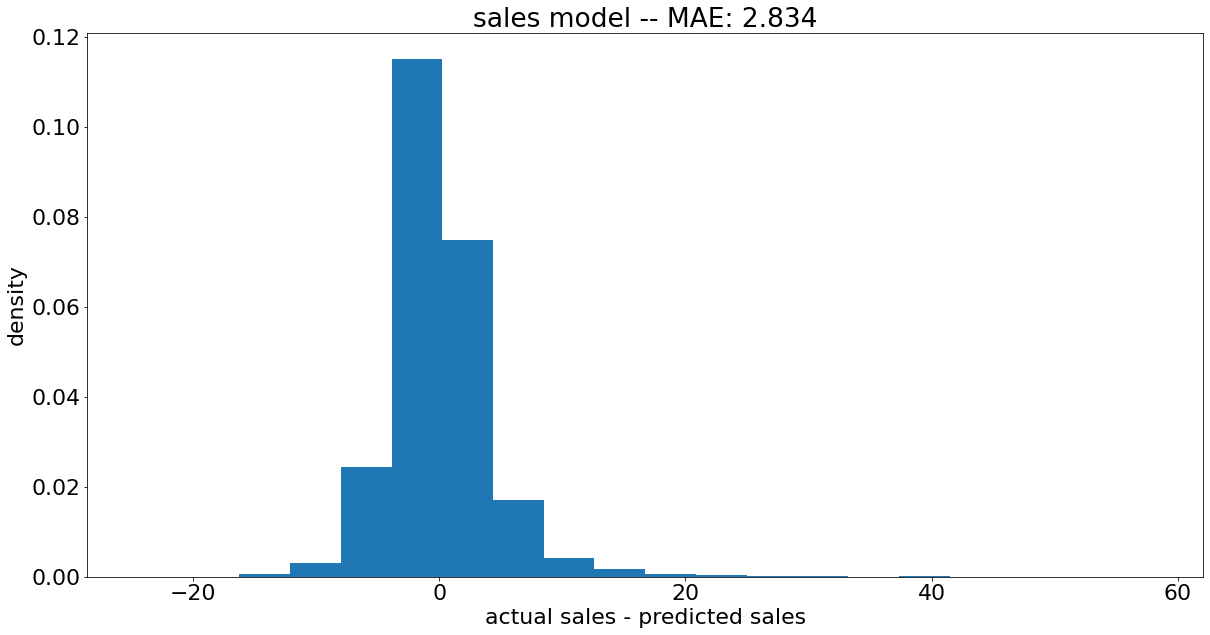

In [345]:
plt.figure(figsize=(20, 10))
plt.hist(sales_diff, bins=20, density=True)
plt.xlabel('actual sales - predicted sales')
plt.ylabel('density')
overall_mae = np.mean(list(ct_key_to_sales_mae.values()))
plt.title(f'sales model -- MAE: {round(overall_mae, 3)}')
plt.show()

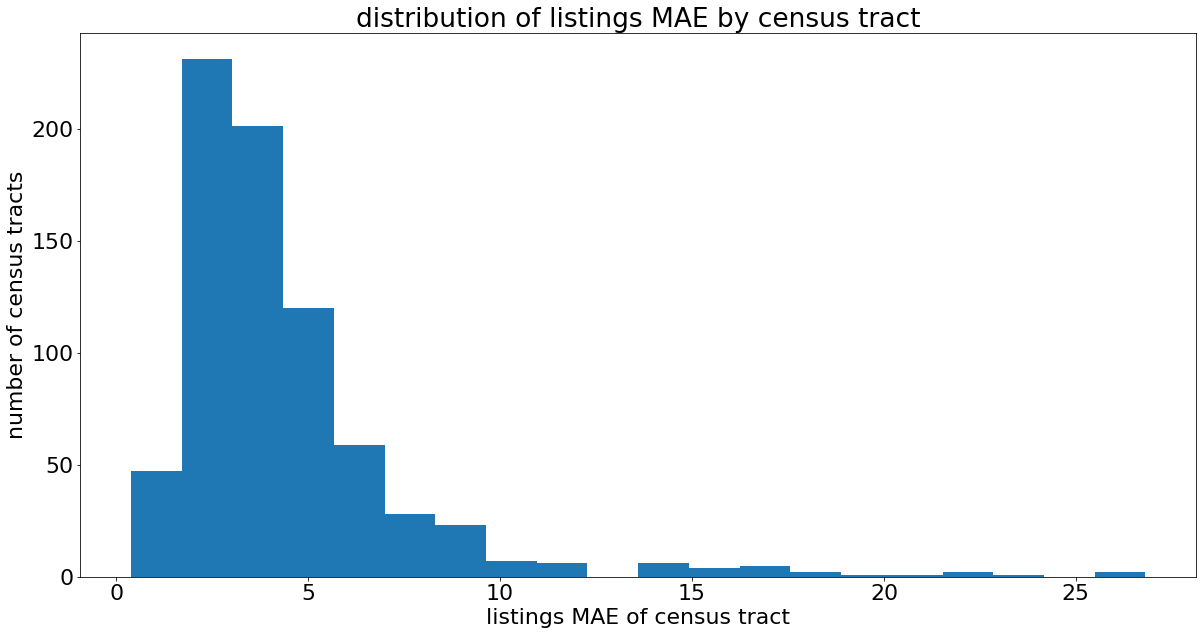

In [126]:
plt.figure(figsize=(20, 10))
plt.hist(list(ct_key_to_listings_mae.values()), bins=20)
plt.xlabel('listings MAE of census tract')
plt.ylabel('number of census tracts')
plt.title('distribution of listings MAE by census tract')
plt.show()

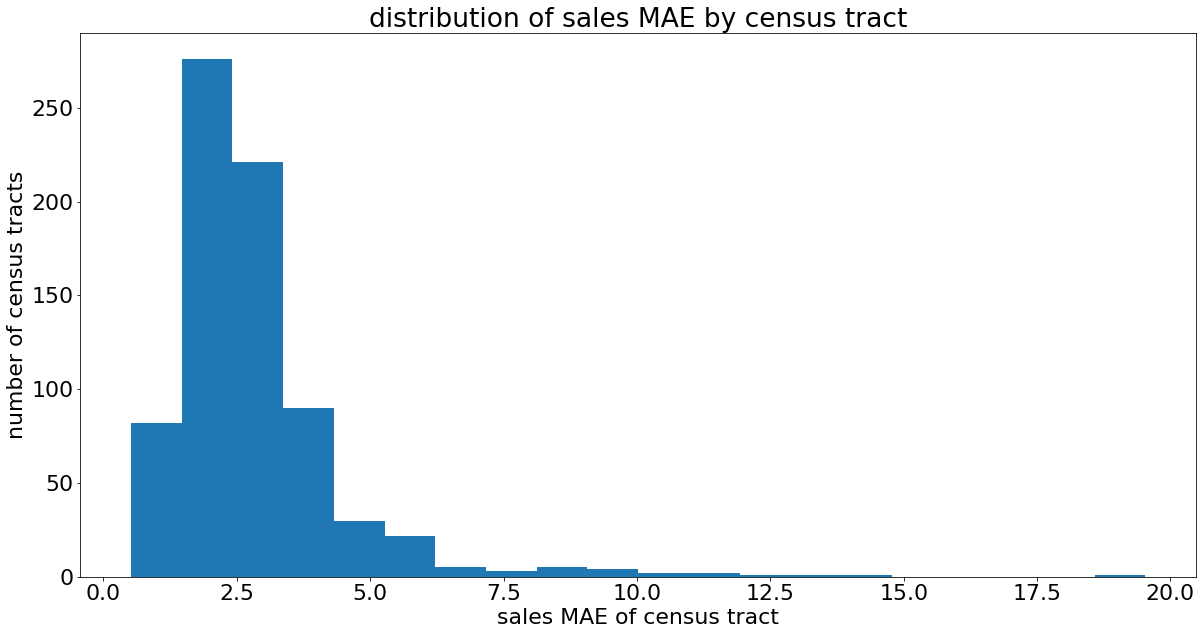

In [127]:
plt.figure(figsize=(20, 10))
plt.hist(list(ct_key_to_sales_mae.values()), bins=20)
plt.xlabel('sales MAE of census tract')
plt.ylabel('number of census tracts')
plt.title('distribution of sales MAE by census tract')
plt.show()

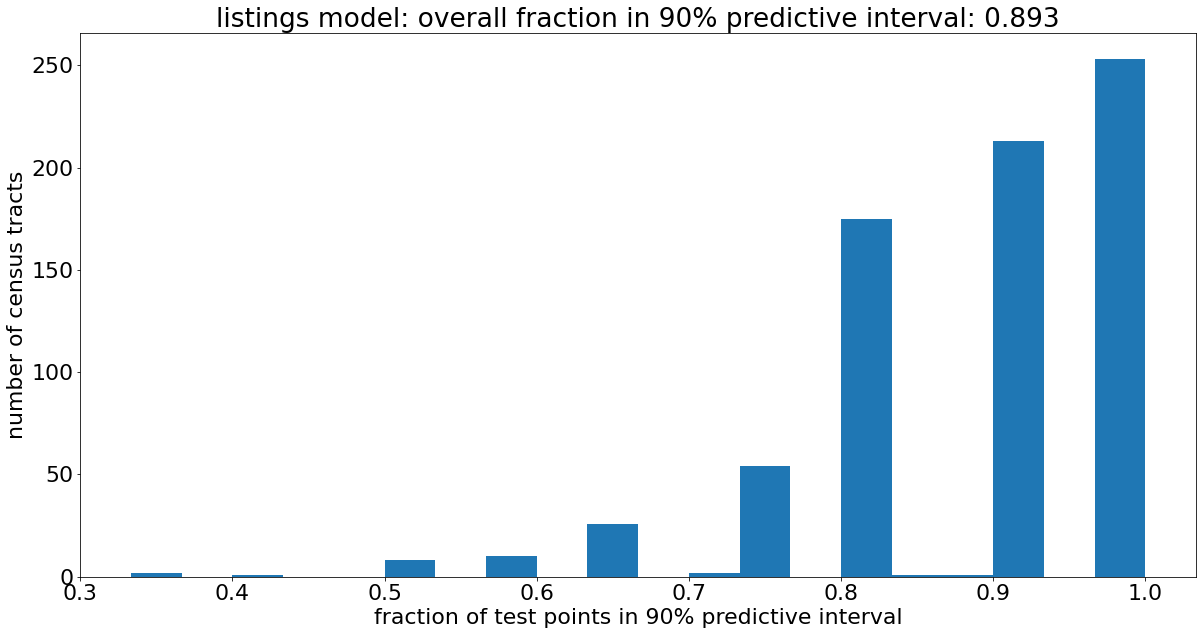

In [128]:
plt.figure(figsize=(20, 10))
listings_in_range_fractions = list(ct_key_to_listings_in_range_fraction.values())
plt.hist(listings_in_range_fractions, bins=20)
plt.xlabel('fraction of test points in 90% predictive interval')
plt.ylabel('number of census tracts')
plt.title(f'listings model: overall fraction in 90% predictive interval: ' +
          f'{round(np.mean(listings_in_range_fractions), 3)}')
plt.show()

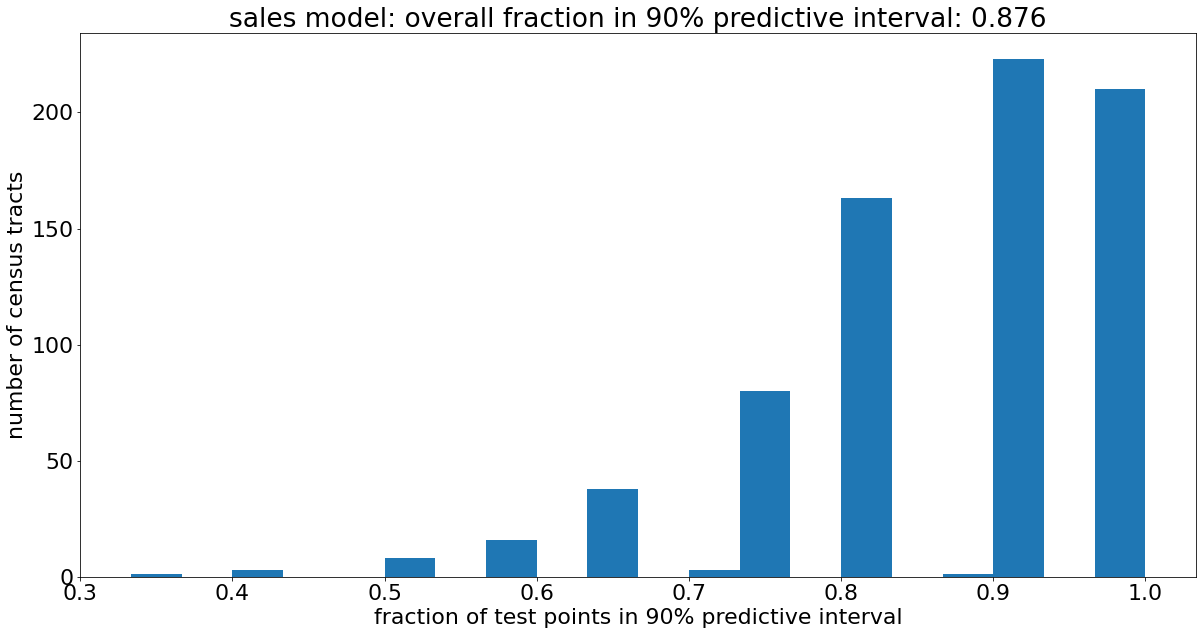

In [129]:
plt.figure(figsize=(20, 10))
sales_in_range_fractions = list(ct_key_to_sales_in_range_fraction.values())
plt.hist(sales_in_range_fractions, bins=20)
plt.xlabel('fraction of test points in 90% predictive interval')
plt.ylabel('number of census tracts')
plt.title(f'sales model: overall fraction in 90% predictive interval: ' +
          f'{round(np.mean(sales_in_range_fractions), 3)}')
plt.show()

## Rolling training window

In [130]:
min_training_months = 1

In [131]:
listings_mae_lst = []
sales_mae_lst = []
training_months_lst = list(range(min_training_months, len(months_sorted) - test_set_months + 1))

for i in training_months_lst:
    train_df = df_merged[df_merged['month'].isin(months_sorted[:i])]
    ratio_param_df = train_df.groupby('ct_key').agg({'relative_listings_toBaseline': np.mean,
                                                     'relative_sales_toBaseline': np.mean})
    ratio_param_df.columns = ['listings_mean', 'sales_mean']
    test_df_temp = pd.merge(test_df, ratio_param_df, left_on='ct_key', right_index=True, how='inner')
    predicted_listings = (test_df_temp['listings_per_households'] * test_df_temp['listings_mean']
                          * test_df_temp['total_households'])
    predicted_sales = (test_df_temp['sales_per_households'] * test_df_temp['sales_mean']
                       * test_df_temp['total_households'])
    
    listings_mae = mean_absolute_error(test_df_temp['ct_count_listings'], predicted_listings)
    sales_mae = mean_absolute_error(test_df_temp['ct_count_sales'], predicted_sales)
    
    listings_mae_lst.append(listings_mae)
    sales_mae_lst.append(sales_mae)

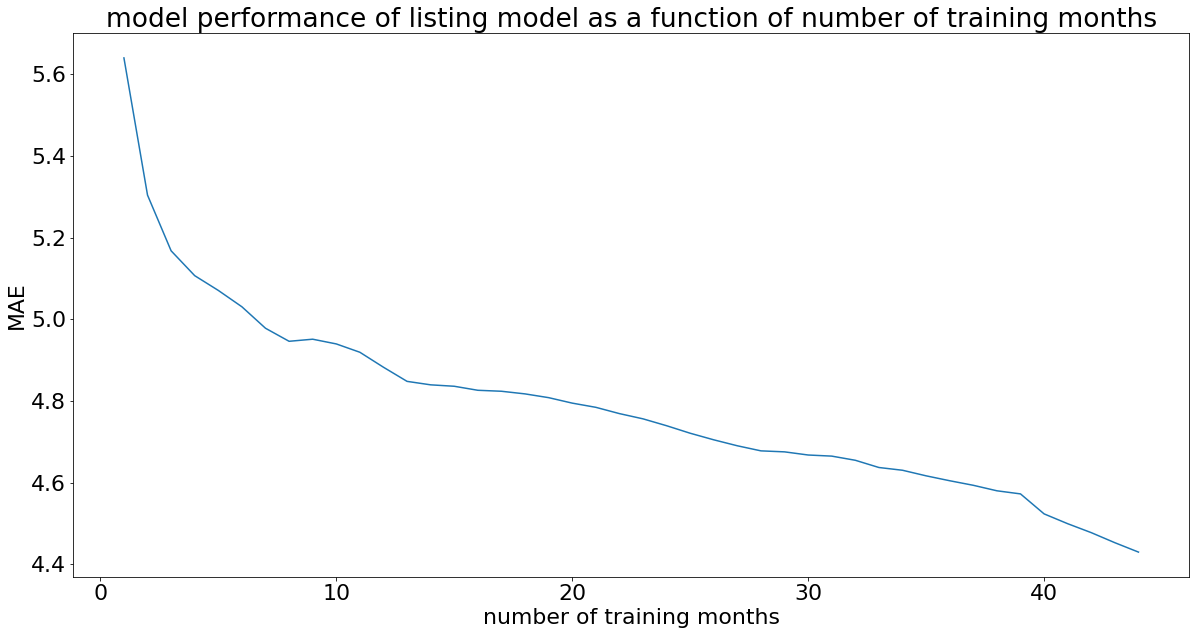

In [132]:
plt.figure(figsize=(20, 10))
plt.plot(training_months_lst, listings_mae_lst)
plt.xlabel('number of training months')
plt.ylabel('MAE')
plt.title('model performance of listing model as a function of number of training months')
plt.show()

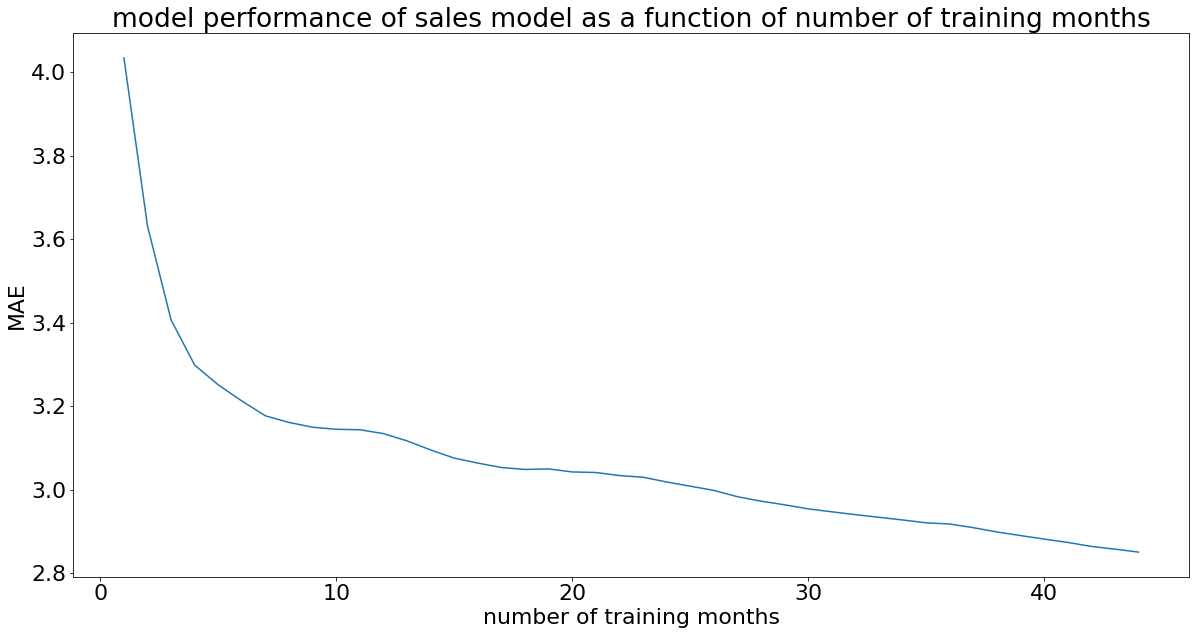

In [133]:
plt.figure(figsize=(20, 10))
plt.plot(training_months_lst, sales_mae_lst)
plt.xlabel('number of training months')
plt.ylabel('MAE')
plt.title('model performance of sales model as a function of number of training months')
plt.show()

## Local training window

### test set is past 12 months

In [150]:
listings_mae_lst = []
sales_mae_lst = []
training_months_lst = list(range(1, len(months_sorted) - test_set_months))

for i in training_months_lst:
    train_df = df_merged[df_merged['month'].isin(months_sorted[-test_set_months - i: -test_set_months])]
    ratio_param_df = train_df.groupby('ct_key').agg({'relative_listings_toBaseline': np.mean,
                                                     'relative_sales_toBaseline': np.mean})
    ratio_param_df.columns = ['listings_mean', 'sales_mean']
    test_df_temp = pd.merge(test_df, ratio_param_df, left_on='ct_key', right_index=True, how='inner')
    predicted_listings = (test_df_temp['listings_per_households'] * test_df_temp['listings_mean']
                          * test_df_temp['total_households'])
    predicted_sales = (test_df_temp['sales_per_households'] * test_df_temp['sales_mean']
                       * test_df_temp['total_households'])
    
    listings_mae = mean_absolute_error(test_df_temp['ct_count_listings'], predicted_listings)
    sales_mae = mean_absolute_error(test_df_temp['ct_count_sales'], predicted_sales)
    
    listings_mae_lst.append(listings_mae)
    sales_mae_lst.append(sales_mae)

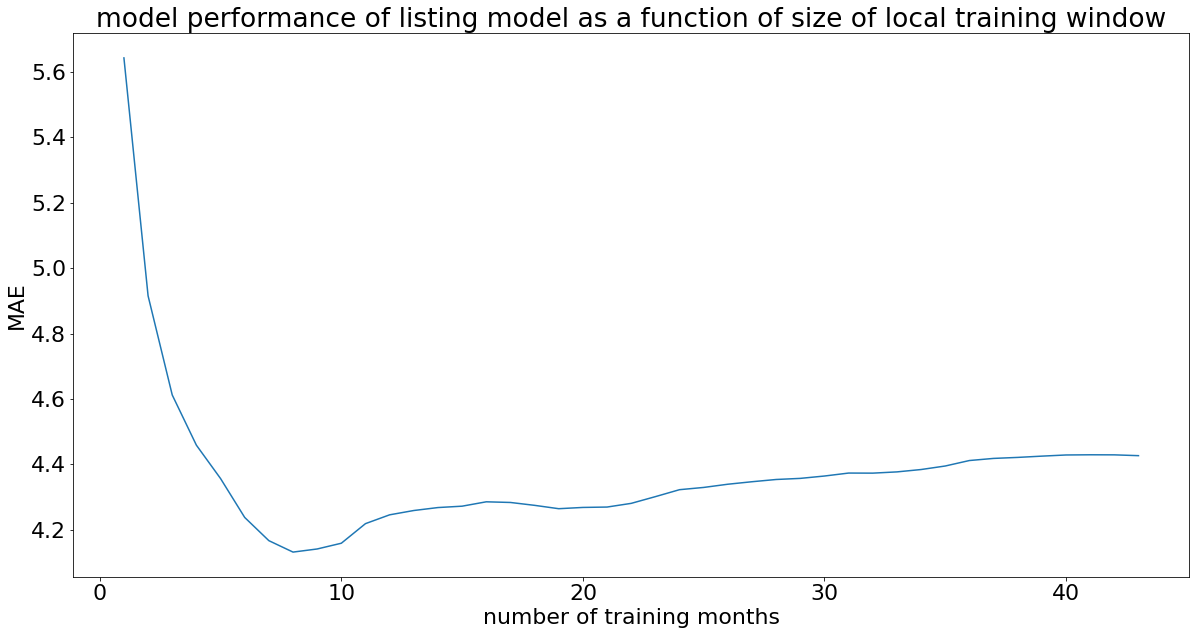

In [153]:
plt.figure(figsize=(20, 10))
plt.plot(training_months_lst, listings_mae_lst)
plt.xlabel('number of training months')
plt.ylabel('MAE')
plt.title('model performance of listing model as a function of size of local training window')
plt.show()

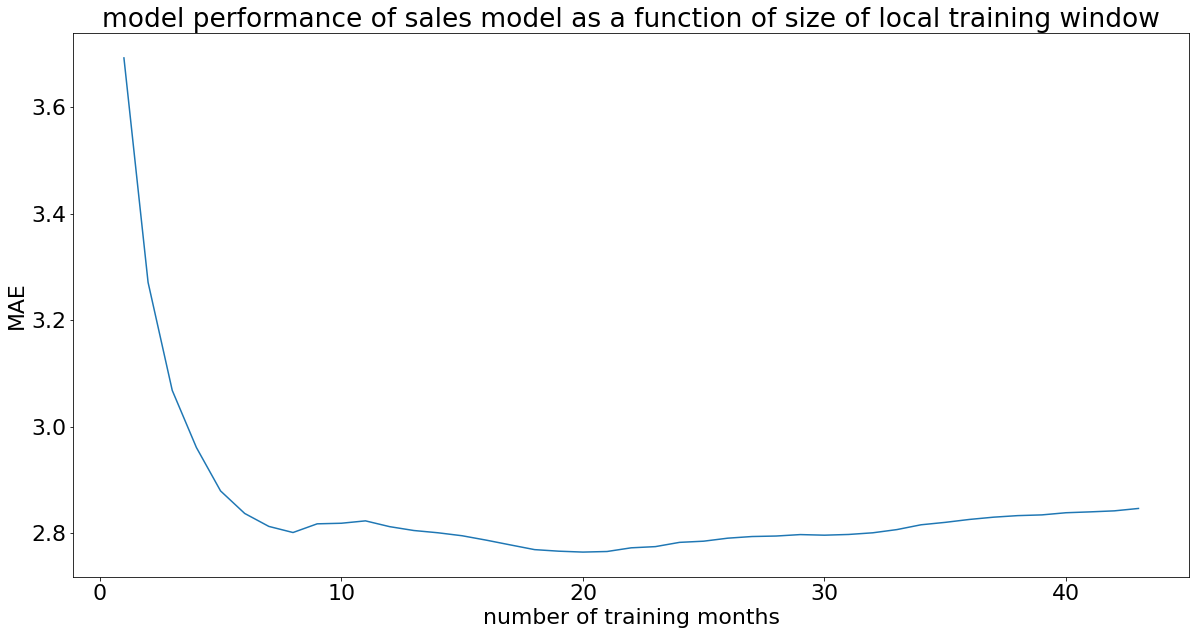

In [154]:
plt.figure(figsize=(20, 10))
plt.plot(training_months_lst, sales_mae_lst)
plt.xlabel('number of training months')
plt.ylabel('MAE')
plt.title('model performance of sales model as a function of size of local training window')
plt.show()

### test set is 24 months to 13 months ago

In [159]:
test_df2 = df_merged[df_merged['month'].isin(months_sorted[-2 * test_set_months: -test_set_months])]

In [160]:
listings_mae_lst = []
sales_mae_lst = []
training_months_lst = list(range(1, len(months_sorted) - 2 * test_set_months))

for i in training_months_lst:
    train_df = df_merged[df_merged['month'].isin(months_sorted[-test_set_months - i: -test_set_months])]
    ratio_param_df = train_df.groupby('ct_key').agg({'relative_listings_toBaseline': np.mean,
                                                     'relative_sales_toBaseline': np.mean})
    ratio_param_df.columns = ['listings_mean', 'sales_mean']
    test_df_temp = pd.merge(test_df2, ratio_param_df, left_on='ct_key', right_index=True, how='inner')
    predicted_listings = (test_df_temp['listings_per_households'] * test_df_temp['listings_mean']
                          * test_df_temp['total_households'])
    predicted_sales = (test_df_temp['sales_per_households'] * test_df_temp['sales_mean']
                       * test_df_temp['total_households'])
    
    listings_mae = mean_absolute_error(test_df_temp['ct_count_listings'], predicted_listings)
    sales_mae = mean_absolute_error(test_df_temp['ct_count_sales'], predicted_sales)
    
    listings_mae_lst.append(listings_mae)
    sales_mae_lst.append(sales_mae)

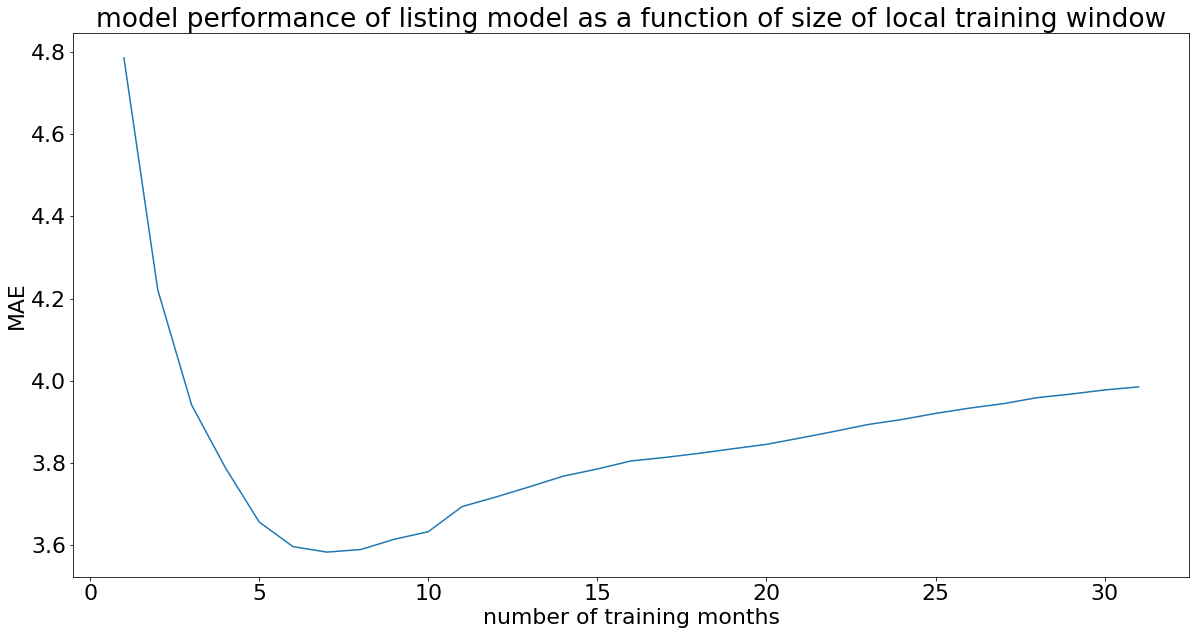

In [161]:
plt.figure(figsize=(20, 10))
plt.plot(training_months_lst, listings_mae_lst)
plt.xlabel('number of training months')
plt.ylabel('MAE')
plt.title('model performance of listing model as a function of size of local training window')
plt.show()

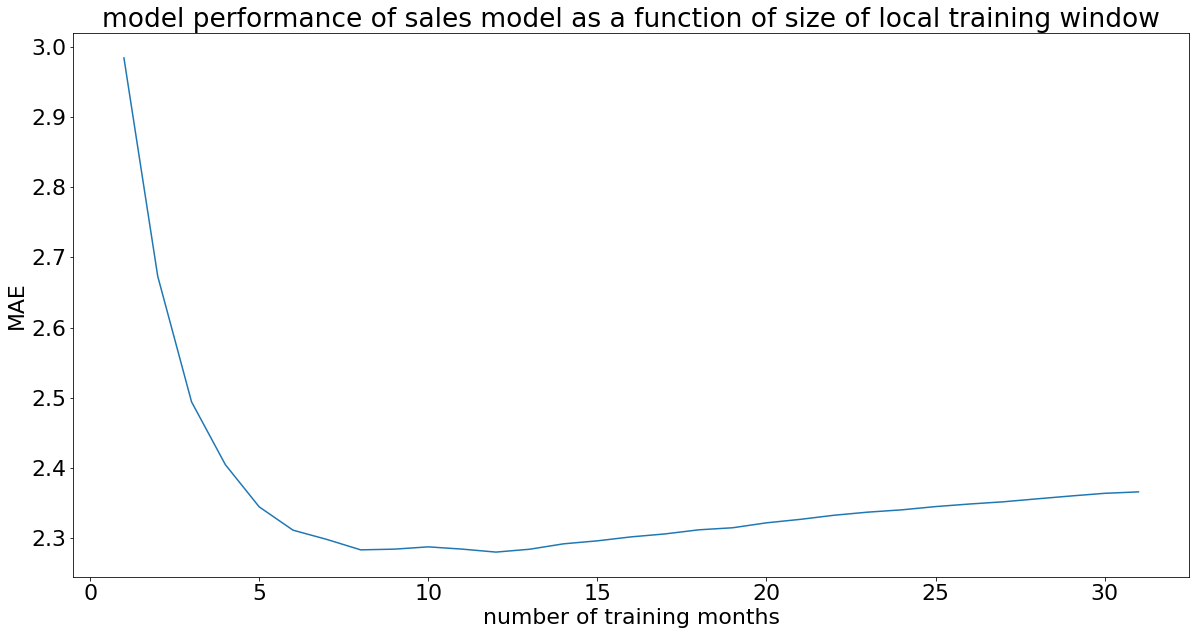

In [162]:
plt.figure(figsize=(20, 10))
plt.plot(training_months_lst, sales_mae_lst)
plt.xlabel('number of training months')
plt.ylabel('MAE')
plt.title('model performance of sales model as a function of size of local training window')
plt.show()

## Predict individual months using previous months

In [318]:
months_num_to_listings_mae_lst = defaultdict(list)
months_num_to_sales_mae_lst = defaultdict(list)
listings_baseline_mae_lst = []
sales_baseline_mae_lst = []

predict_ahead_months = 3
first_month = 20
for i in range(first_month, len(months_sorted)):
    for j in range(predict_ahead_months, first_month + 1):
        train_df = df_merged[df_merged['month'].isin(months_sorted[i - j: i - (predict_ahead_months - 1)])]
        ratio_param_df = train_df.groupby('ct_key').agg({'relative_listings_toBaseline': np.mean,
                                                         'relative_sales_toBaseline': np.mean})
        ratio_param_df.columns = ['listings_mean', 'sales_mean']
        test_df2 = df_merged[df_merged['month'] == months_sorted[i]]
        test_df_temp = pd.merge(test_df2, ratio_param_df, left_on='ct_key', right_index=True, how='inner')
    
        predicted_listings = (test_df_temp['listings_per_households'] * test_df_temp['listings_mean']
                              * test_df_temp['total_households'])
        predicted_sales = (test_df_temp['sales_per_households'] * test_df_temp['sales_mean']
                           * test_df_temp['total_households'])
        
        predicted_listings_baseline = test_df_temp['listings_per_households'] * test_df_temp['total_households']
        predicted_sales_baseline = test_df_temp['sales_per_households'] * test_df_temp['total_households']
    
        listings_mae = mean_absolute_error(test_df_temp['ct_count_listings'], predicted_listings)
        sales_mae = mean_absolute_error(test_df_temp['ct_count_sales'], predicted_sales)
        
        
        months_num_to_listings_mae_lst[j].append(listings_mae)
        months_num_to_sales_mae_lst[j].append(sales_mae)
        
    listings_mae_baseline = mean_absolute_error(test_df_temp['ct_count_listings'], 
                                                    predicted_listings_baseline)
    sales_mae_baseline = mean_absolute_error(test_df_temp['ct_count_sales'], predicted_sales_baseline)
        
    listings_baseline_mae_lst.append(listings_mae_baseline)
    sales_baseline_mae_lst.append(sales_mae_baseline)

In [319]:
print('listings baseline mean MSE:', np.mean(listings_baseline_mae_lst))
print('sales baseline mean MSE:', np.mean(sales_baseline_mae_lst))

listings baseline mean MSE: 5.459235536196333
sales baseline mean MSE: 3.7461291029980086


In [320]:
mean_mae_listings = [np.mean(mae_lst) for mae_lst in months_num_to_listings_mae_lst.values()]
mean_mae_sales = [np.mean(mae_lst) for mae_lst in months_num_to_sales_mae_lst.values()]
mean_mae_listings_baseline = [np.mean(mae_lst) for mae_lst in months_num_to_listings_baseline_mae_lst.values()]
mean_mae_sales_baseline = [np.mean(mae_lst) for mae_lst in months_num_to_sales_baseline_mae_lst.values()]

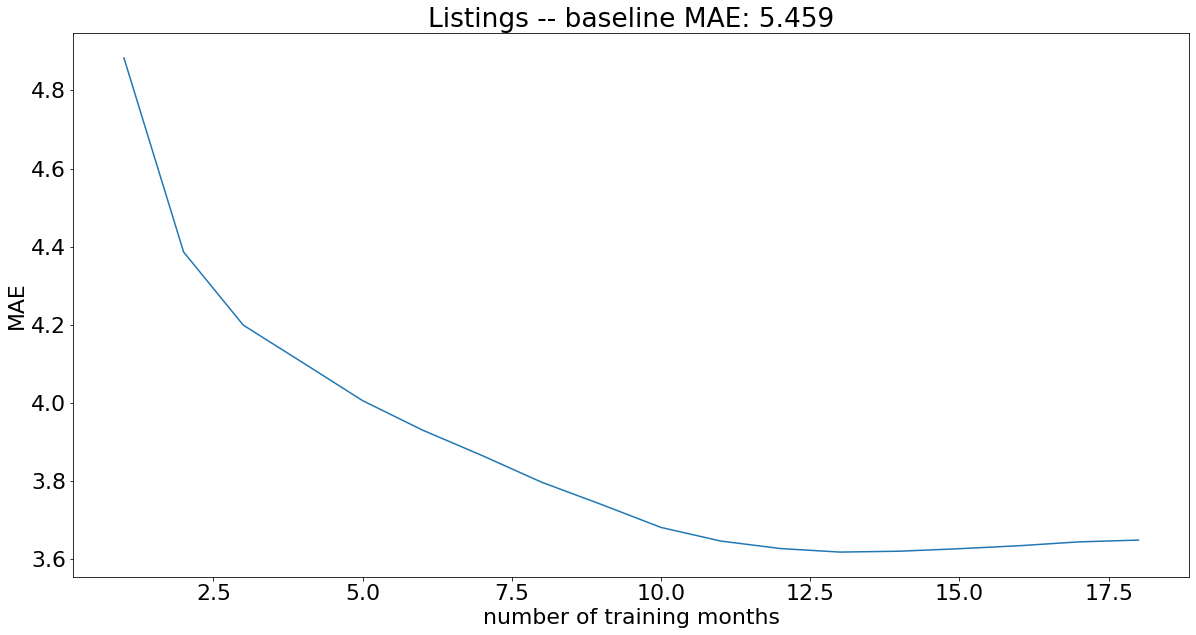

In [321]:
training_months_num_lst = np.array(list(months_num_to_listings_mae_lst.keys())) - (predict_ahead_months - 1)
plt.figure(figsize=(20, 10))
plt.plot(training_months_num_lst, mean_mae_listings)
plt.xlabel('number of training months')
plt.ylabel('MAE')
plt.title(f'Listings -- baseline MAE: {round(np.mean(listings_baseline_mae_lst), 3)}')
plt.show()

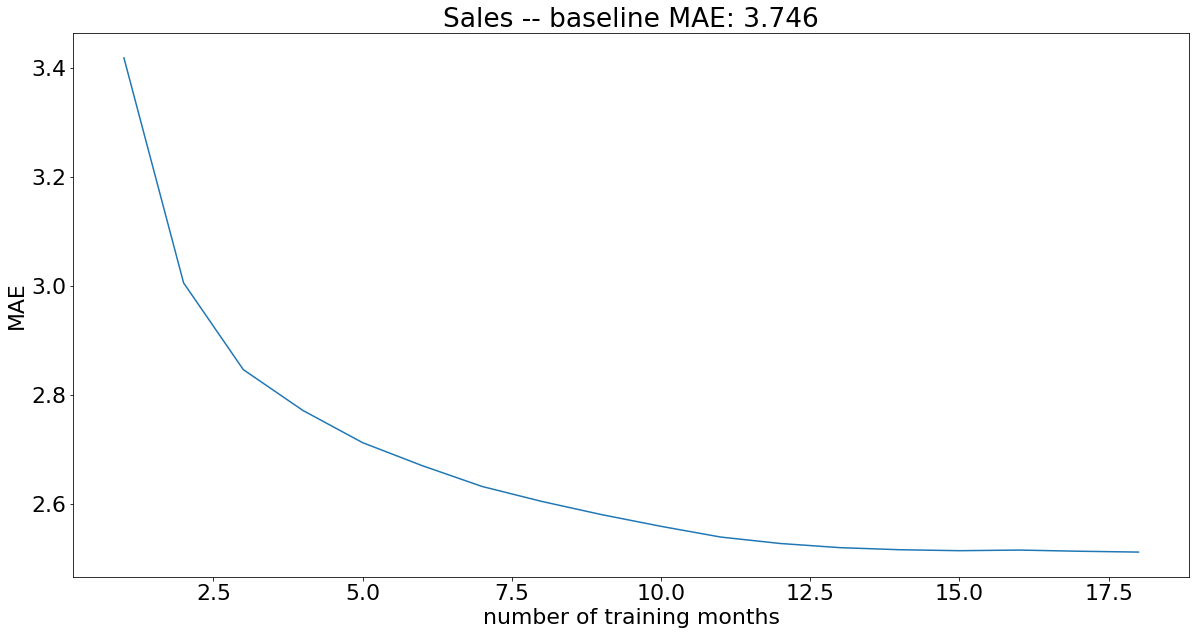

In [322]:
plt.figure(figsize=(20, 10))
plt.plot(training_months_num_lst, mean_mae_sales)
plt.xlabel('number of training months')
plt.ylabel('MAE')
plt.title(f'Sales -- baseline MAE: {round(np.mean(sales_baseline_mae_lst), 3)}')
plt.show()